<a href="https://colab.research.google.com/github/GulnazaS/parkinsons-disease-detector/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B7%D0%BD%D0%B8_%D0%BF%D0%B0%D1%80%D0%BA%D0%B8%D0%BD%D1%81%D0%BE%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [5]:
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
import warnings

# Отключение предупреждений
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/content/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [8]:
#Размерность массива
df.shape

(195, 24)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [10]:
# Поиск нулевых значений
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

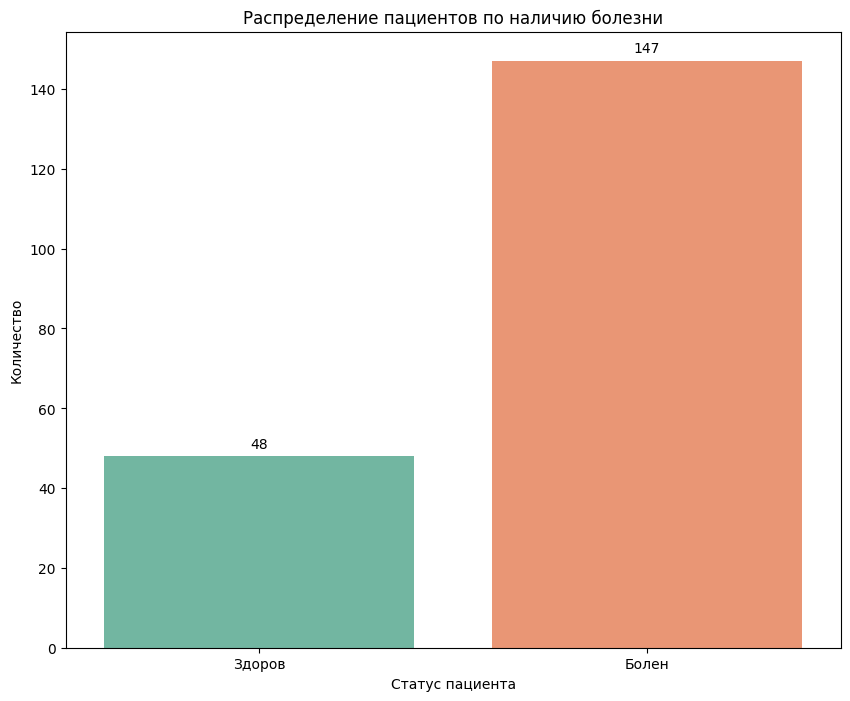

In [11]:
status = ['Здоров', 'Болен']
plt.figure(figsize=(10,8))
sns.countplot(x=df['status'], palette='Set2')
plt.xlabel('Статус пациента')
plt.ylabel('Количество')
plt.title("Распределение пациентов по наличию болезни")

# Переименование оси X на слова
plt.gca().set_xticklabels(status)

# Добавление значений к каждому столбцу
ax = plt.gca()
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

<Axes: >

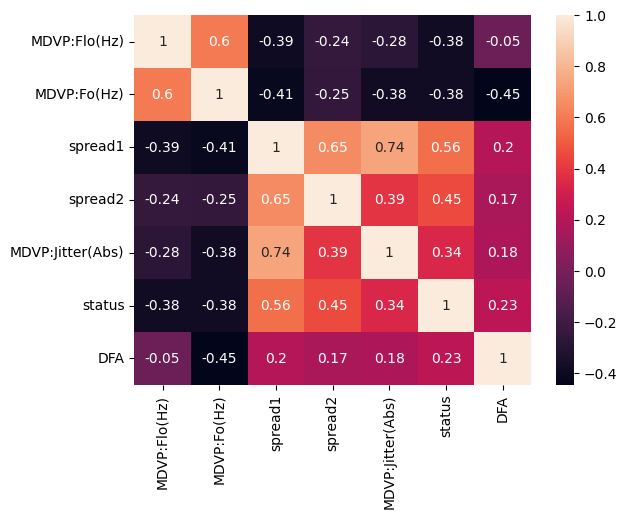

In [12]:
sns.heatmap(df[['MDVP:Flo(Hz)', 'MDVP:Fo(Hz)','spread1','spread2','MDVP:Jitter(Abs)', 'status', 'DFA']].corr(), annot = True)

In [17]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


<Axes: ylabel='Frequency'>

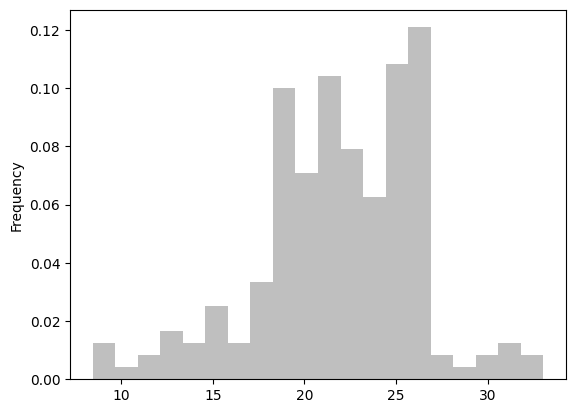

In [24]:
#df.hwy.plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey')
df.HNR.plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey')

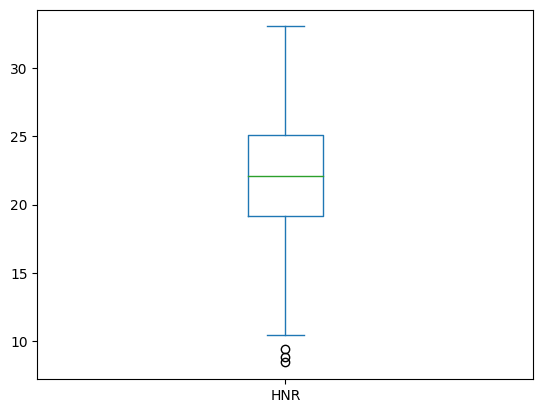

In [25]:
_, bp = df.HNR.plot.box(return_type='both')

In [26]:
outliers = [flier.get_ydata() for flier in bp["fliers"]][0]
df[df.HNR.isin(outliers)]

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
100,phon_R01_S24_4,125.641,141.068,116.346,0.03316,0.00026,0.02144,0.01522,0.06433,0.09178,...,0.16074,0.31482,8.867,1,0.671299,0.656846,-3.700544,0.260481,2.991063,0.370961
151,phon_R01_S35_6,192.818,224.429,168.793,0.03107,0.00016,0.01800,0.01958,0.05401,0.11908,...,0.16942,0.21713,8.441,1,0.625866,0.768320,-2.434031,0.450493,3.079221,0.527367
152,phon_R01_S35_7,198.116,233.099,174.478,0.02714,0.00014,0.01568,0.01699,0.04705,0.08684,...,0.12851,0.16265,9.449,1,0.584164,0.754449,-2.839756,0.356224,3.184027,0.454721


In [13]:
df['status'].value_counts()

1    147
0     48
Name: status, dtype: int64

In [43]:
x = df[['MDVP:Fo(Hz)','MDVP:Fhi(Hz)','MDVP:Flo(Hz)',
                                                   'MDVP:Jitter(%)','MDVP:Jitter(Abs)',	'MDVP:RAP',
                                                   'MDVP:PPQ', 'Jitter:DDP','MDVP:Shimmer', 'MDVP:Shimmer(dB)',
                                                   'Shimmer:DDA','NHR','HNR','RPDE','DFA','spread1','spread2',
                                                   'D2','PPE','Shimmer:APQ3','Shimmer:APQ5', 'MDVP:APQ']]

y = df['status']

In [40]:
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.2, random_state=7)

In [41]:
xgbc = XGBClassifier()

In [44]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(xgbc, param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]})

In [55]:
#TEST
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = XGBClassifier()

param_grid = {
'max_depth': [3, 4, 5],
'learning_rate': [0.01, 0.1, 0.2],
'n_estimators': [50, 100, 150]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)

random_search.fit(x_train, y_train)

best_model = random_search.best_estimator_

y_pred = best_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели на тестовой выборке: {accuracy*100}%')

Точность модели на тестовой выборке: 94.87179487179486%


In [58]:
print("Cреднее значение оценки кросс-валидации : %.2f" % kf_cv_scores.mean())

Cреднее значение оценки кросс-валидации : 0.90


In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 5  2]
 [ 0 32]]


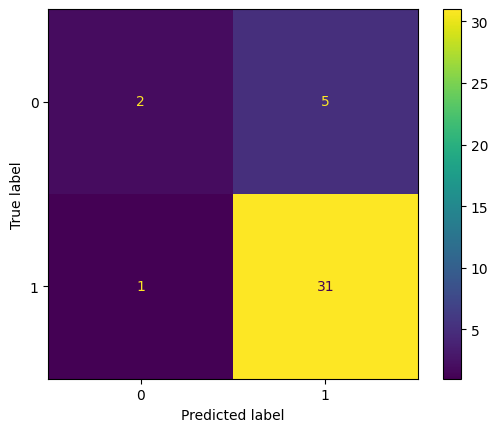

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
clf = SVC(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Text(0.5, 23.52222222222222, 'Предсказанный статус пациента')

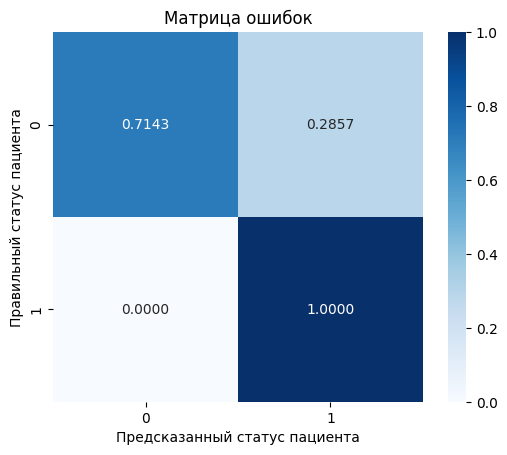

In [61]:
confusion = confusion_matrix(y_test, y_pred,labels=[0,1])
confusion_normalized = confusion/confusion.sum(axis=1, keepdims=True)
axis_labels = range(2)
ax = sns.heatmap(
                confusion_normalized,
                xticklabels=axis_labels,
                yticklabels=axis_labels,
                cmap='Blues',
                annot=True,
                fmt='.4f',
                square=True
                )
plt.title("Матрица ошибок")
plt.ylabel("Правильный статус пациента")
plt.xlabel("Предсказанный статус пациента")

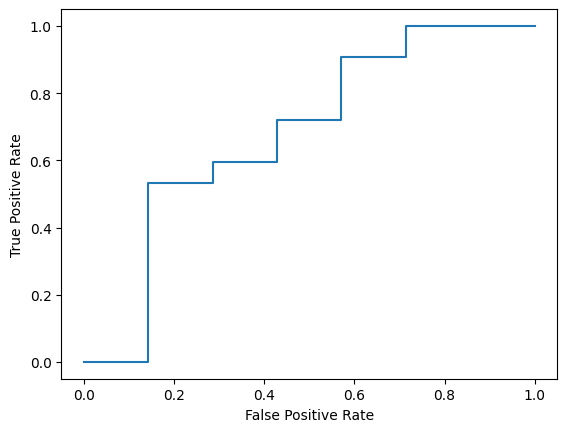

In [62]:
from sklearn.metrics import RocCurveDisplay, roc_curve

y_score = clf.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

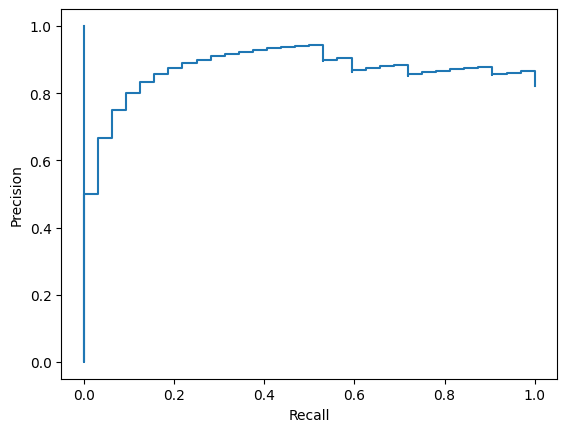

In [63]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [64]:
svc = SVC(random_state=42)
svc.fit(x_train, y_train)

SVC(random_state=42)

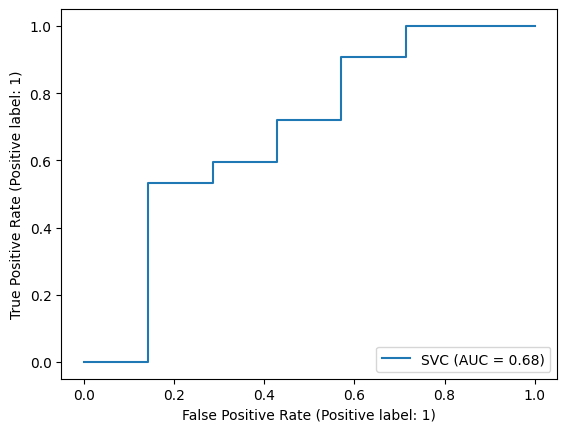

In [65]:
svc_disp = RocCurveDisplay.from_estimator(svc, x_test, y_test)
plt.show()

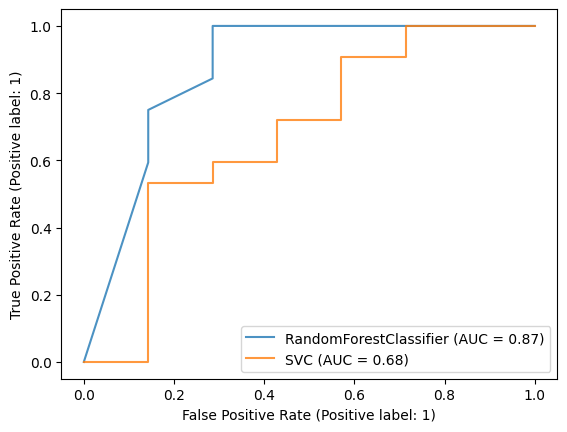

In [66]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(x_train, y_train)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, x_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()